Ignacio Vellido Expósito

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
################################################################################
# Libraries
################################################################################

import cv2
import os

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
################################################################################
# Load data
################################################################################

# Adaptación de:
# https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
def load_images_from_folder(folder, resize_shape = None, subset_shape = None):
    images = []

    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            if resize_shape is not None:
              img = cv2.resize(img, resize_shape)

            shape = img.shape
            if subset_shape is not None:
              i = np.random.randint(0,shape[0] - subset_shape[0])
              j = np.random.randint(0,shape[1] - subset_shape[1])
              img = img[i : i+subset_shape[0], j : j+subset_shape[1]]

            images.append(img)

    return np.array(images)


path = "/content/drive/MyDrive/VC-T3/data/"
shape = (128,64)

pedestrians    = load_images_from_folder(path + "pedestrians128x64")
no_pedestrians = load_images_from_folder(path + "pedestrians_neg", (512,512), shape)

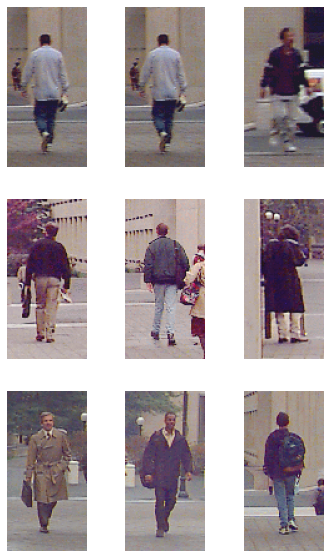

In [ ]:
################################################################################
# Visualize data
################################################################################
plt.figure(figsize=(6, 10))

for i, img in enumerate(pedestrians[0:9]):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.axis("off")

plt.show()

Parece que los peatones están siempre centrados, pero el fondo y la pose varía.

Al menos en estas fotos las figuras se distinguen al completo y no están parcialmente tapadas. Además, la gama de colores es similar en todas ellas.

También parece que tenemos datos repetidos

In [ ]:
print(pedestrians.shape)
np.unique(pedestrians, axis=0).shape

(924, 128, 64, 3)


(920, 128, 64, 3)

4 imágenes repetidas

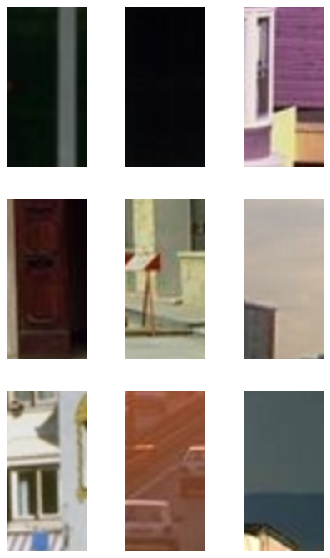

In [ ]:
plt.figure(figsize=(6, 10))

for i, img in enumerate(no_pedestrians[0:9]):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.axis("off")

plt.show()

In [ ]:
################################################################################
# HOG
################################################################################

def interpolate(mag, angle, min, max):
  lower = mag * ((max-angle) / (max-min))
  upper = mag * ((angle-min) / (max-min))
  return (upper,lower)

# ------------------------------------------------------------------------------

def get_histogram(cell):
  shape = cell[0].shape

  bins = [10,30,50,70,90,110,130,150,170,180]
  hist  = np.zeros_like(bins, dtype="float32")

  for i in range(shape[0]):
    for j in range(shape[1]):
      angle = cell[0][i,j]
      magni = cell[1][i,j]

      # If angle < 10, only sum in h(10)
      if angle <= bins[0]:
        hist[0] += magni
      else: # In other case, interpolate
        for b in range(len(bins)-1):
          if angle > bins[b] and angle <= bins[b+1]:
            (upper,lower) = interpolate(magni, angle, bins[b], bins[b+1])
            hist[b]   += upper
            hist[b+1] += lower

  return hist

# ------------------------------------------------------------------------------

def hog(img):
  # Set to grayscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Calculate gradients
  mask = np.array([[-1,0,1]], dtype="float32")
  vertical   = cv2.filter2D(img, -1, mask)
  horizontal = cv2.filter2D(img, -1, mask.T)

  vertical = np.array(vertical, dtype="float32")
  horizontal = np.array(horizontal, dtype="float32")

  # Numpy
  # magnitude   = np.sqrt(horizontal**2  + vertical**2)
  # orientation = np.arctan2(vertical, horizontal) + 90
  
  # OpenCV 
  magnitude, orientation = cv2.cartToPolar(vertical, horizontal, angleInDegrees=1)

  # -------------------------------------------------------

  # Plot gradients
  # magnitude = np.array(magnitude, dtype="uint8")
  # orientation = np.array(orientation, dtype="uint8")

  # plt.imshow(vertical, "gray")
  # plt.show()
  # plt.imshow(horizontal, "gray")
  # plt.show()
  # plt.imshow(magnitude, "gray")
  # plt.show()
  # plt.imshow(orientation, "gray")
  # plt.show()

  # -------------------------------------------------------

  cell_size = 8
  cells_height = img.shape[0] // cell_size # Número de células a lo largo
  cells_width  = img.shape[1] // cell_size # Número de células a lo ancho
  
  # Get histogram for each cell
  nbins = 10
  cells  = np.zeros((cells_height, cells_width, nbins))

  for i in range(cells_height):
    for j in range(cells_width):
      ori = orientation[i*cells_height:(i+1)*cells_height, j*cells_width:(j+1)*cells_width]
      mag = magnitude[i*cells_height:(i+1)*cells_height, j*cells_width:(j+1)*cells_width]

      cells[i,j] = get_histogram((ori,mag))
  
  # -------------------------------------------------------

  # Join cells in groups of 4
  block_height = cells_height // 2
  block_width = cells_width // 2

  blocks = np.zeros((block_height, block_width, 4 * nbins))

  for i in range(blocks.shape[0]):
    for j in range(blocks.shape[1]):
      c1 = cells[2*i,   2*j]
      c2 = cells[2*i,   2*j+1]
      c3 = cells[2*i+1, 2*j]
      c4 = cells[2*i+1, 2*j+1]

      # Concatenate histograms for each block
      blocks[i,j] = np.concatenate([c1,c2,c3,c4])

      # Normalize
      blocks[i,j] = blocks[i,j] / (np.linalg.norm(blocks[i,j]) + 0.01)

  # -------------------------------------------------------

  # Get HOG, normalize and saturate
  blocks = blocks.reshape((block_height * block_width * 4 * nbins))
  hog = blocks / (np.linalg.norm(blocks) + 0.01)
  hog = np.clip(hog, 0, 0.2)

  return hog

In [ ]:
################################################################################
# Preprocess data
################################################################################

# Get subset of 400 images
pedestrians = pedestrians[np.random.randint(pedestrians.shape[0], size=400)]

x = np.concatenate([pedestrians, no_pedestrians])

# Get HOGs
x = np.array(list(map(hog, x)))

# Get labels
y = np.concatenate([np.ones(pedestrians.shape[0]), np.zeros(no_pedestrians.shape[0])])

# Train test split
tst_size = 0.2
trn_x, tst_x, trn_y, tst_y = train_test_split(x, y, test_size = tst_size)

In [ ]:
################################################################################
# Train data
################################################################################

model = SVC()

model.fit(trn_x, trn_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
################################################################################
# Test model
################################################################################

def get_scores(model, x, y, subset):
  pred = model.predict(x)

  acc = accuracy_score(y, pred)
  pre = precision_score(y, pred)
  rec = recall_score(y, pred)
  f1  = f1_score(y, pred)

  metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1"])
  metrics.loc[0] = [acc, pre, rec, f1]
  
  print(metrics)

  plot_auc(y, pred, subset)

  plot_confusion_matrix(model, x, y, values_format="d")
  plt.show()

# ------------------------------------------------------------------------------

def evaluate_model(model, trn_x, trn_y, tst_x, tst_y):
  print("Train")
  get_scores(model, trn_x, trn_y, "Train")
  print("----------------------------------\n")
  print("Test")
  get_scores(model, tst_x, tst_y, "Test")
  print("\n")

# ------------------------------------------------------------------------------

def plot_auc(y, preds,subset):
  fpr, tpr, threshold = roc_curve(y, preds)
  roc_auc = auc(fpr, tpr)

  plt.title("AUC {}".format(subset))
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

Train
   Accuracy  Precision  Recall   F1
0       1.0        1.0     1.0  1.0


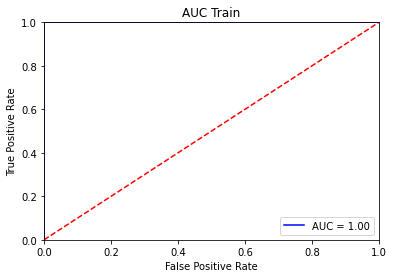

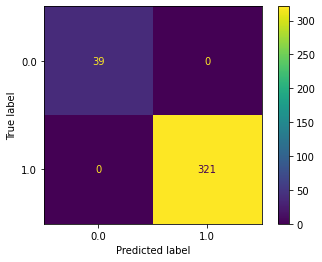

----------------------------------

Test
   Accuracy  Precision  Recall        F1
0  0.966667   0.963415     1.0  0.981366


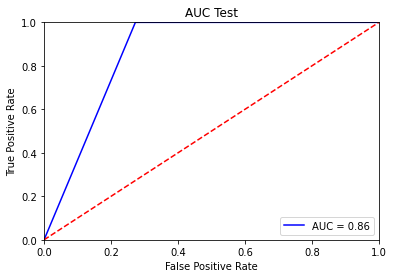

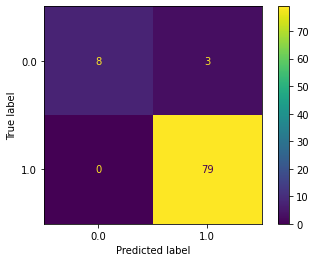

In [ ]:
################################################################################
# Test data
################################################################################

evaluate_model(model, trn_x, trn_y, tst_x, tst_y)